In [18]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from tqdm import tqdm
plt.style.use('seaborn-poster')
mpl.rcParams
%matplotlib inline

In [2]:
mpl.rcParams['image.origin'] = 'lower'

In [3]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [4]:
driv = ppy.driver.Driver(iso_model)

In [5]:
gal = ppy.galaxy.TauFull()
gal.set_params(np.array([0., -2., 3., 3., 25.]))

In [6]:
def get_pcmd(logNpix, dmod, Nim=512):
    gal.set_params(np.array([0., -2., logNpix, 3., dmod]))
    return driv.simulate(gal, Nim, shot_noise=False)[0]

In [39]:
def dmod_to_mpc(dmod):
    return 10.**(0.2*dmod + 1)/1e6

In [41]:
dmod_to_mpc(30.)

10.0

In [87]:
Nx, Ny = 11, 11
logNs = np.linspace(1, 6, Nx)
dmods = np.linspace(25, 35, Ny)
d_mpc = dmod_to_mpc(dmods)

sig_intrinsic = np.zeros((Nx, Ny), dtype=float)
n_bar = np.zeros((Nx, Ny), dtype=float)

for i, logN in tqdm(enumerate(logNs), total=Nx):
    for j, dmod in tqdm(enumerate(dmods), leave=False, total=Ny, disable=True):
        pcmd = get_pcmd(logN, dmod, Nim=512)
        mags = pcmd[0]
        sig_intrinsic[i,j] = np.std(mags)
        n_bar[i,j] = np.mean(f[0].mag_to_counts(mags) / f[0]._exposure)

In [130]:
alpha = 0.2
x = 10.**(alpha * sig_intrinsic / 1.25)
t = (x+1)**2 / ((x-1)**2 * n_bar)        

In [125]:
ratios = {}
exp_ts = np.logspace(2, 4, 100)
def shot_ratio(i):
    y = np.outer(np.sqrt(exp_ts), n_bar[:, i])
    term1 = y + np.sqrt(n_bar[:,i])
    term2 = y - np.sqrt(n_bar[:,i])
    return 1.25*np.log10(term1/term2) / sig_intrinsic[:, i]

ratios['1mpc'] = shot_ratio(0)
ratios['10mpc'] = shot_ratio(5)
ratios['100mpc'] = shot_ratio(10)

/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


/n/home01/bcook/.local/lib/python3.6/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


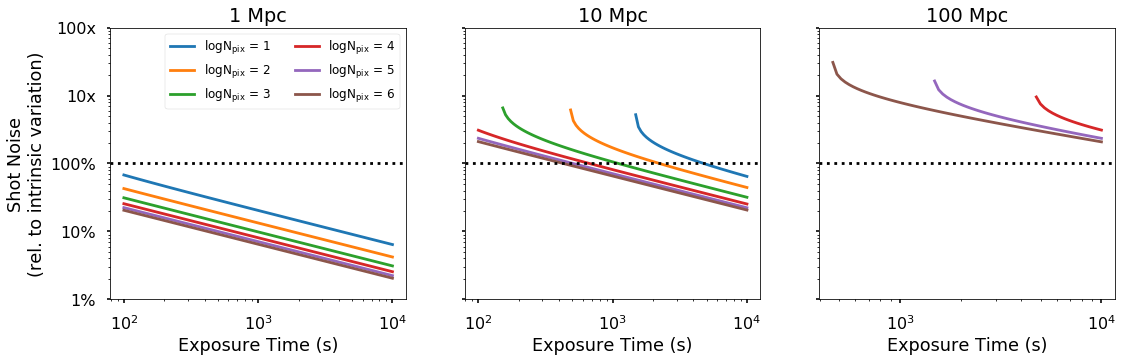

In [151]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
ax = axes[0]
for i, N in enumerate(logNs[::2]):
    ax.plot(exp_ts, 100.*ratios['1mpc'][:, i], label=r'$\log$N$_\mathrm{pix}$ = ' + '{:.0f}'.format(N))
ax.set_title('1 Mpc')
ax.set_ylabel('Shot Noise\n(rel. to intrinsic variation)')
ax.legend(loc=0, fontsize=12, ncol=2)

ax = axes[1]
for i, N in enumerate(logNs[::2]):
    ax.plot(exp_ts, 100.*ratios['10mpc'][:, i], label=r'$\log$N$_\mathrm{pix}$ = ' + '{:.0f}'.format(N))
ax.set_title('10 Mpc')

ax = axes[2]
for i, N in enumerate(logNs[::2]):
    ax.plot(exp_ts, 100.*ratios['100mpc'][:, i], label=r'$\log$N$_\mathrm{pix}$ = ' + '{:.0f}'.format(N))
ax.set_title('100 Mpc')

ax.set_ylim([1, 10000])
for ax in axes:
    ax.axhline(y=100, ls=':', color='k')
    ax.set_xlabel('Exposure Time (s)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
ax = axes[0]
ax.set_yticks([1, 10, 100, 1000, 10000])
ax.set_yticklabels(['1%', '10%', '100%', '10x', '100x'])
plt.savefig('figures/shotnoise_by_exptime.pdf')

In [156]:
pix_1mpc = 0.05*(np.pi / (3600*180)) * 1e8
pix_1mpc**-2

0.0017018068118460877

In [158]:
1e4/1.7e-3

5882352.941176471

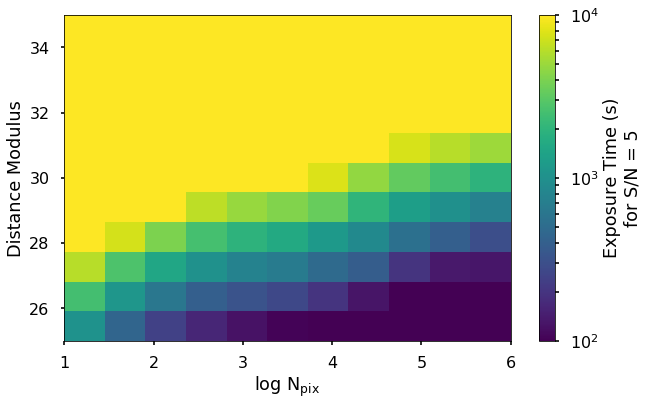

In [137]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(t.T, extent=[logNs[0], logNs[-1], dmods[0], dmods[-1]], aspect='auto', norm=mpl.colors.LogNorm(), vmin=100, vmax=1e4)
ax.set_xlabel(r'$\log$ N$_\mathrm{pix}$')
ax.set_ylabel('Distance Modulus')

plt.colorbar(label='Exposure Time (s)\nfor S/N = 5')
plt.savefig('figures/exptime_map.pdf')

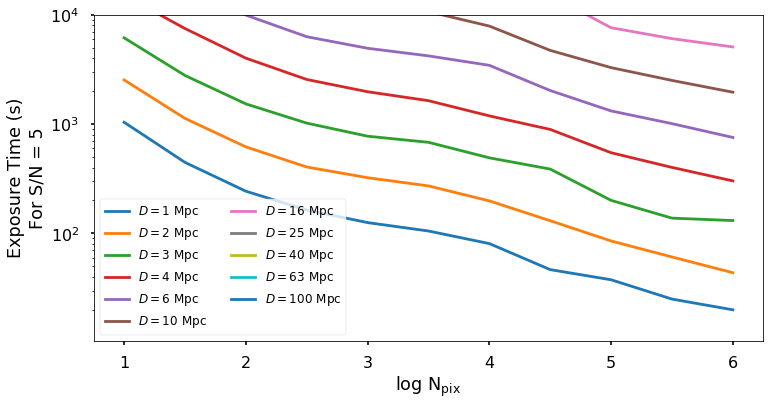

In [139]:
fig, ax = plt.subplots(figsize=(12, 6))
for i, dmod in enumerate(dmods):
    ax.plot(logNs, t[:, i], label=r'$D = $' + '{:.0f} Mpc'.format(dmod_to_mpc(dmod)))
ax.set_yscale('log')
ax.set_xlabel(r'$\log$ N$_\mathrm{pix}$')
ax.set_ylabel('Exposure Time (s)\nFor S/N = 5')
ax.legend(ncol=2, fontsize=12)
ax.set_ylim(ymax=1e4)
plt.savefig('figures/exptime_by_Npix.pdf')